# Getting Started

This notebook outlines the best operating practices for mapping a given quantum circuit to real IBM backends. As an example, we'll use the problem statement from [this manuscript](https://arxiv.org/abs/2108.09197), quantum simulation of an Ising model Hamiltonian:
$$
H = -J \sum_{\langle i,j \rangle} Z_i Z_j + h \sum_i X_i
$$
where $J$ is the exchange coupling between adjacent spins and $h$ is the transverse magnetic field. Here $X_i$ and $Z_j$ are the Pauli matrices acting on qubits $i$ and $j$, respectively.

In [1]:
from qiskit import transpile
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.opflow import I, X, Z, PauliTrotterEvolution, Suzuki
from qiskit.test.mock import FakeMumbai

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")

/var/folders/lz/ccbfpt8928jglgv0n8q2lxw00000gn/T/ipykernel_1639/1885903916.py:4: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeMumbai


In [2]:
num_spins = 3

JJ = Parameter("J")
hh = Parameter("h")
tt = Parameter("t")

ham = -JJ * sum(
    [
        sum(
            [
                (I ^ idx) ^ Z ^ (I ^ jdx) ^ Z ^ (I ^ (num_spins - idx - jdx - 2))
                for jdx in range(num_spins - idx - 1)
            ]
        )
        for idx in range(num_spins - 1)
    ]
) + hh * sum([(I ^ idx) ^ X ^ (I ^ (num_spins - idx - 1)) for idx in range(num_spins)])
U_ham = (ham * tt).exp_i()
print(U_ham)

e^(-i*1.0*t * SummedOp([
  -1.0*J * (
    1.0 * ZZI
    + 1.0 * ZIZ
    + 1.0 * IZZ
  ),
  1.0*h * (
    1.0 * XII
    + 1.0 * IXI
    + 1.0 * IIX
  )
]))


**Note**: Since many of these transpilation steps are computationally intensive, it may make sense to break up your circuit into smaller subcircuits, and then combine them together to get the final circuit. This is naturally acheived for Trotterized algorithms, since `reps` here just repeats the same circuit `num_steps` times, hence we just set `num_steps=1` and the resulting circuits can be combined into as many steps as desired later.

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


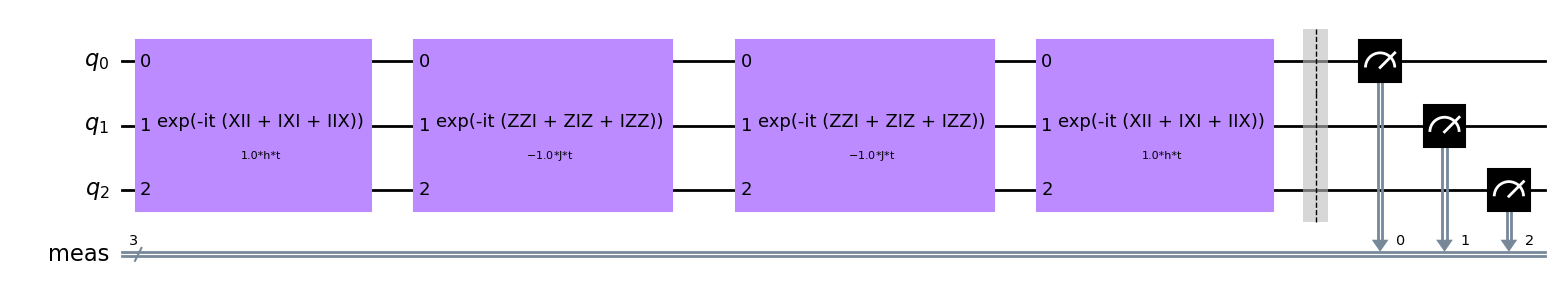

In [3]:
num_steps = 1
trot_circ = (
    PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=num_steps))
    .convert(U_ham)
    .to_circuit()
)
trot_circ.measure_all()
trot_circ.draw("mpl")

## Transpile for Good SWAP Mapping

While the Ising Hamiltonian is a nearest-neighbor interaction, in general problems must respect the layout of the actual quantum hardware. Due to limited connectivity, this often entails doing SWAP operations to move quantum information around. SWAPs are costly in the sense they consist of three `CX`s. The Qiskit transpiler with `optimization_level=3` uses the SABRE SWAP method, which is efficient, however stochastic, since the SWAP-mapping problem is NP-hard. 

This operation serves only to minimize the number of SWAPs in the transpiled circuits, and is not aware of noise on the underlying qubits. That is considered in a following step.

In [4]:
# TODO - check issue with floats not being rounded off

num_tries = 10

backend = FakeMumbai()
trot_circ_ts = transpile(
    [trot_circ] * num_tries, backend, optimization_level=3, seed_transpiler=12345
)
cx_counts = [trot_circ_ts[idx].count_ops()["cx"] for idx in range(num_tries)]
print(cx_counts)

[26, 26, 26, 26, 26, 26, 26, 26, 26, 26]


In [5]:
best_idx = np.argmin(cx_counts)
trot_circ_t = trot_circ_ts[best_idx]

Due to the nearest-neighbor structure of this problem, the number of `CX`s is unaffected by the stochastic nature of the SWAP mapper, however, this is not true in general.

Now that we have a SWAP-mapped optimal circuit, we consider the layouts on the actual quantum backend. This process "deflates" the circuit (by removing idle qubits) and scores different layouts due to error rates, which are calculated by a cost function that considers gate error rates and $T_1$/$T_2$ times by default.

In [6]:
from mapomatic import deflate_circuit, evaluate_layouts, matching_layouts

trot_circ_def = deflate_circuit(trot_circ_t)
layouts = matching_layouts(trot_circ_def, backend)
scored_layouts = evaluate_layouts(trot_circ_def, layouts, backend)
print(scored_layouts)

[([22, 19, 20], 0.19559875042718045), ([20, 19, 22], 0.19725649661357325), ([4, 7, 10], 0.19965672881426533), ([10, 7, 4], 0.20034675008891367), ([19, 22, 25], 0.20604063113181614), ([25, 22, 19], 0.20735474632819384), ([2, 3, 5], 0.2126845680885847), ([26, 25, 22], 0.214818945894926), ([5, 3, 2], 0.2148207558503763), ([22, 25, 26], 0.21592923251095508), ([26, 25, 24], 0.2212775495056506), ([24, 25, 26], 0.223038253655217), ([4, 7, 6], 0.2289583365670348), ([7, 10, 12], 0.2290008003436642), ([12, 10, 7], 0.22910066080742186), ([22, 25, 24], 0.23150457934882296), ([24, 25, 22], 0.23215638944301997), ([17, 18, 21], 0.23478767200759465), ([21, 18, 17], 0.23509220244123186), ([23, 21, 18], 0.23657038973700217), ([18, 21, 23], 0.23710273302300833), ([6, 7, 4], 0.2380689632120604), ([11, 14, 16], 0.2382179773578127), ([16, 14, 11], 0.2384268101894792), ([11, 14, 13], 0.24074103324290508), ([13, 14, 11], 0.24157113046714707), ([16, 14, 13], 0.24335107476834494), ([13, 14, 16], 0.2439710627396

## Pulse Scaling

The next method is particularly suited to problems in quantum simulation because the Trotterization of the unitary evolution operator `U_ham` involved interactions that are typically much smaller than the angle $\pi/2$ used to generate a `CX` from an `RZXGate`, which itself is close to what the [cross resonance entangling](https://arxiv.org/abs/1603.04821) achieves. 

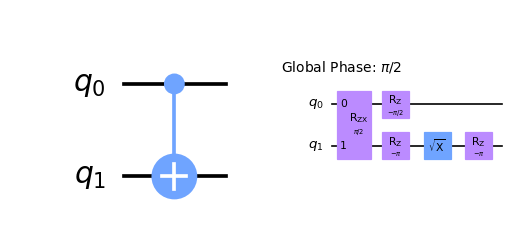

In [7]:
# TODO: check out Weyl decomp stuff

qc = QuantumCircuit(2)
qc.cx(0, 1)
qc_rzx = transpile(qc, basis_gates=["sx", "rz", "rzx"])

fig, (ax1, ax2) = plt.subplots(1, 2)
qc.draw("mpl", ax=ax1)
qc_rzx.draw("mpl", ax=ax2)

Since we are implementing two-qubit rotation angles less than $\pi/2$, we can more efficiently express these interaction in terms of $R_{ZX}(\theta)$ rotations and directly build them from scaled cross resonance pulses obtained from the backend, as detailed in [this manuscript](http://arxiv.org/abs/2012.11660). This method first uses a greedy algorithm called [template opimization](http://arxiv.org/abs/1909.05270) to identify parts of the circuit that can be substituted by $R_{ZX}$ rotations. If parameters are passed to the method, it will bind them to the circuit and attach the necessary pulse gates for implementing the $R_{ZX}$ rotations. Below we will do that separately, because we will attach a series of `Parameter`s as a function of time, and it is more efficient to do the template optimization step once since it is greedy and attaching the pulse schedules in quick.

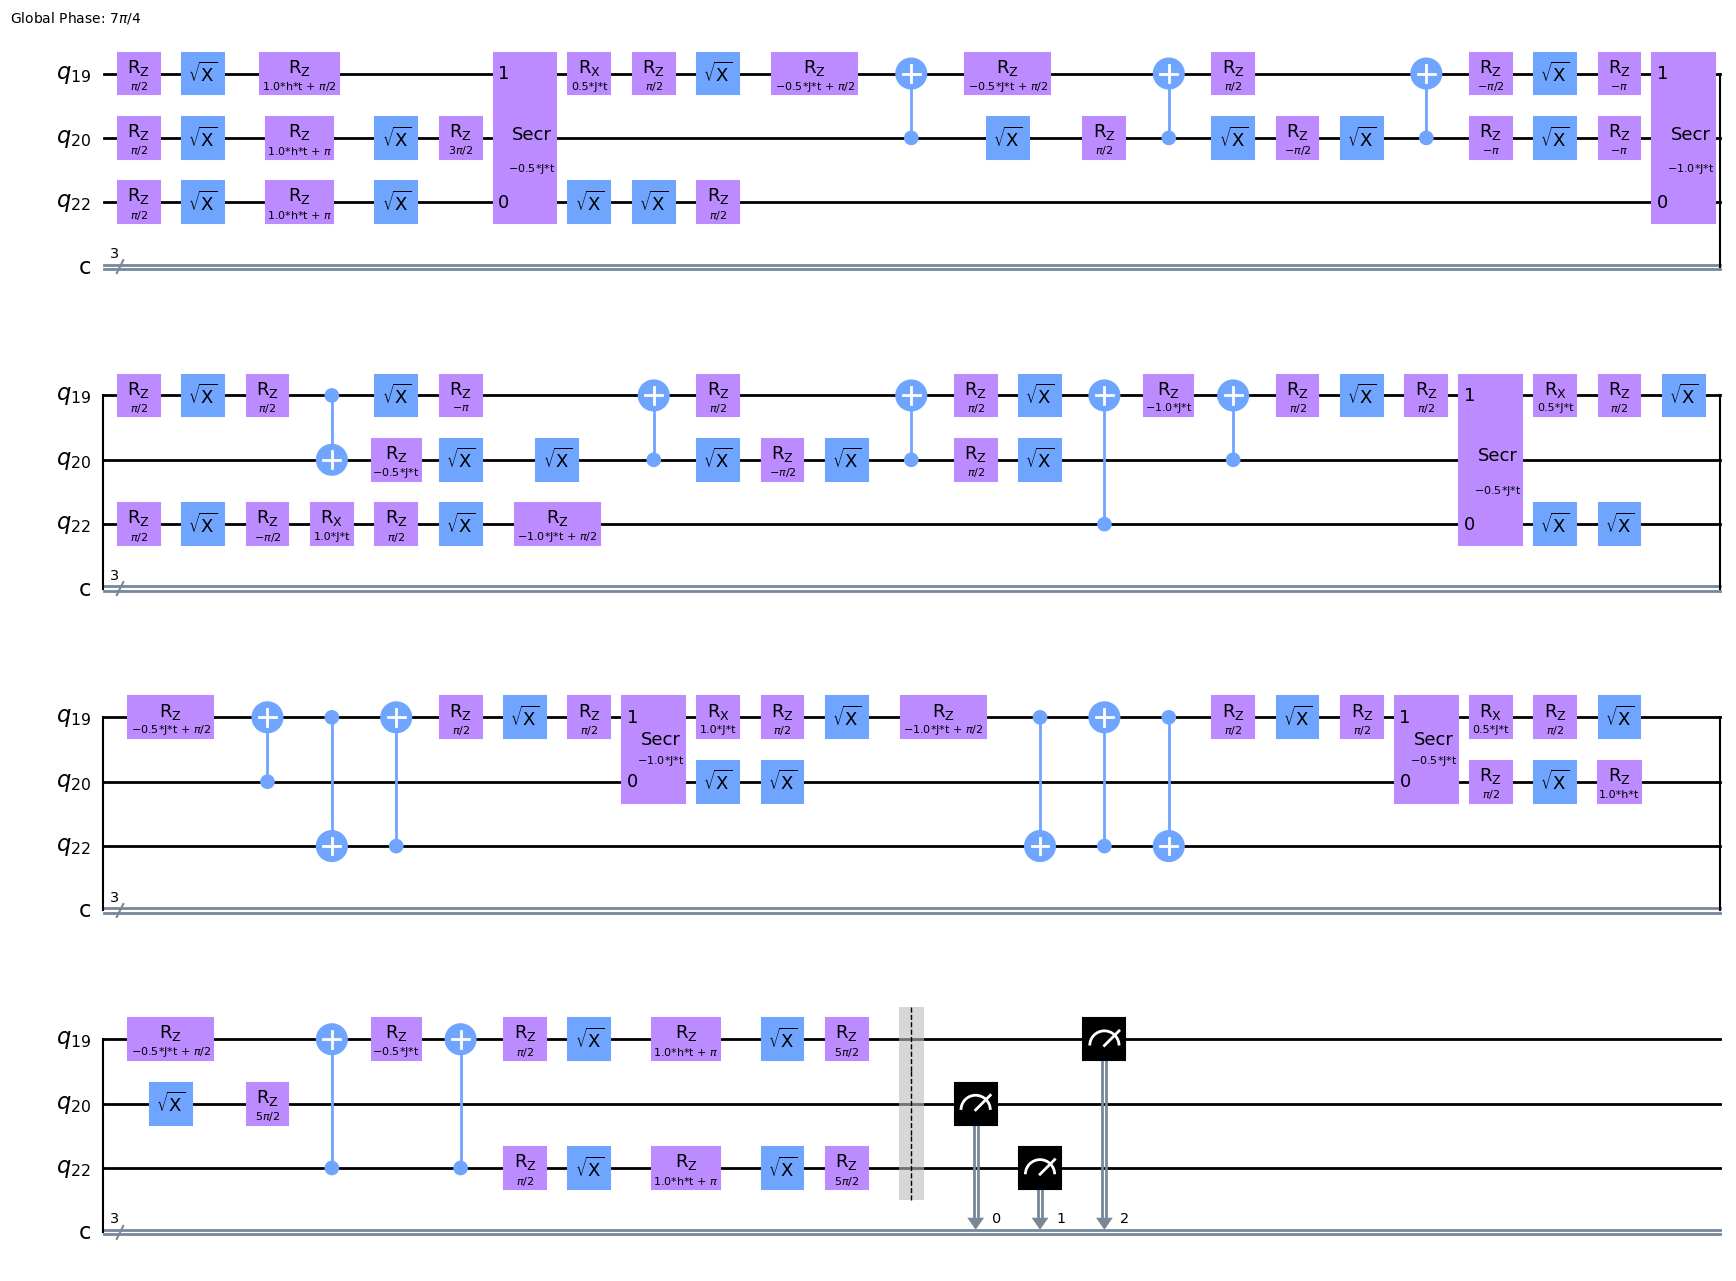

In [8]:
# TODO: add simple demo of how template optimization works

from qiskit_research.utils.convenience import scale_cr_pulses

my_layout = scored_layouts[0][0]  # the layout with the lowest score (i.e., error)
trot_circ_sca = scale_cr_pulses(
    transpile(trot_circ_def, initial_layout=my_layout), backend
)
trot_circ_sca.draw("mpl", idle_wires=False)

In [9]:
from qiskit_research.utils.convenience import attach_cr_pulses

t_range = np.linspace(0, 10, 51)
param_bind = {JJ: 0.5236, hh: 1}

circs = []
for t_set in t_range:
    param_bind[tt] = t_set
    circs.append(attach_cr_pulses(trot_circ_sca, backend, param_bind))

## Pauli Twirling

In [10]:
from qiskit_research.utils.convenience import add_pauli_twirls

# this returns a circuit with shape len(circs) x num_twirled_circuits
twirled_circs = add_pauli_twirls(circs, num_twirled_circuits=8, seed=12345)

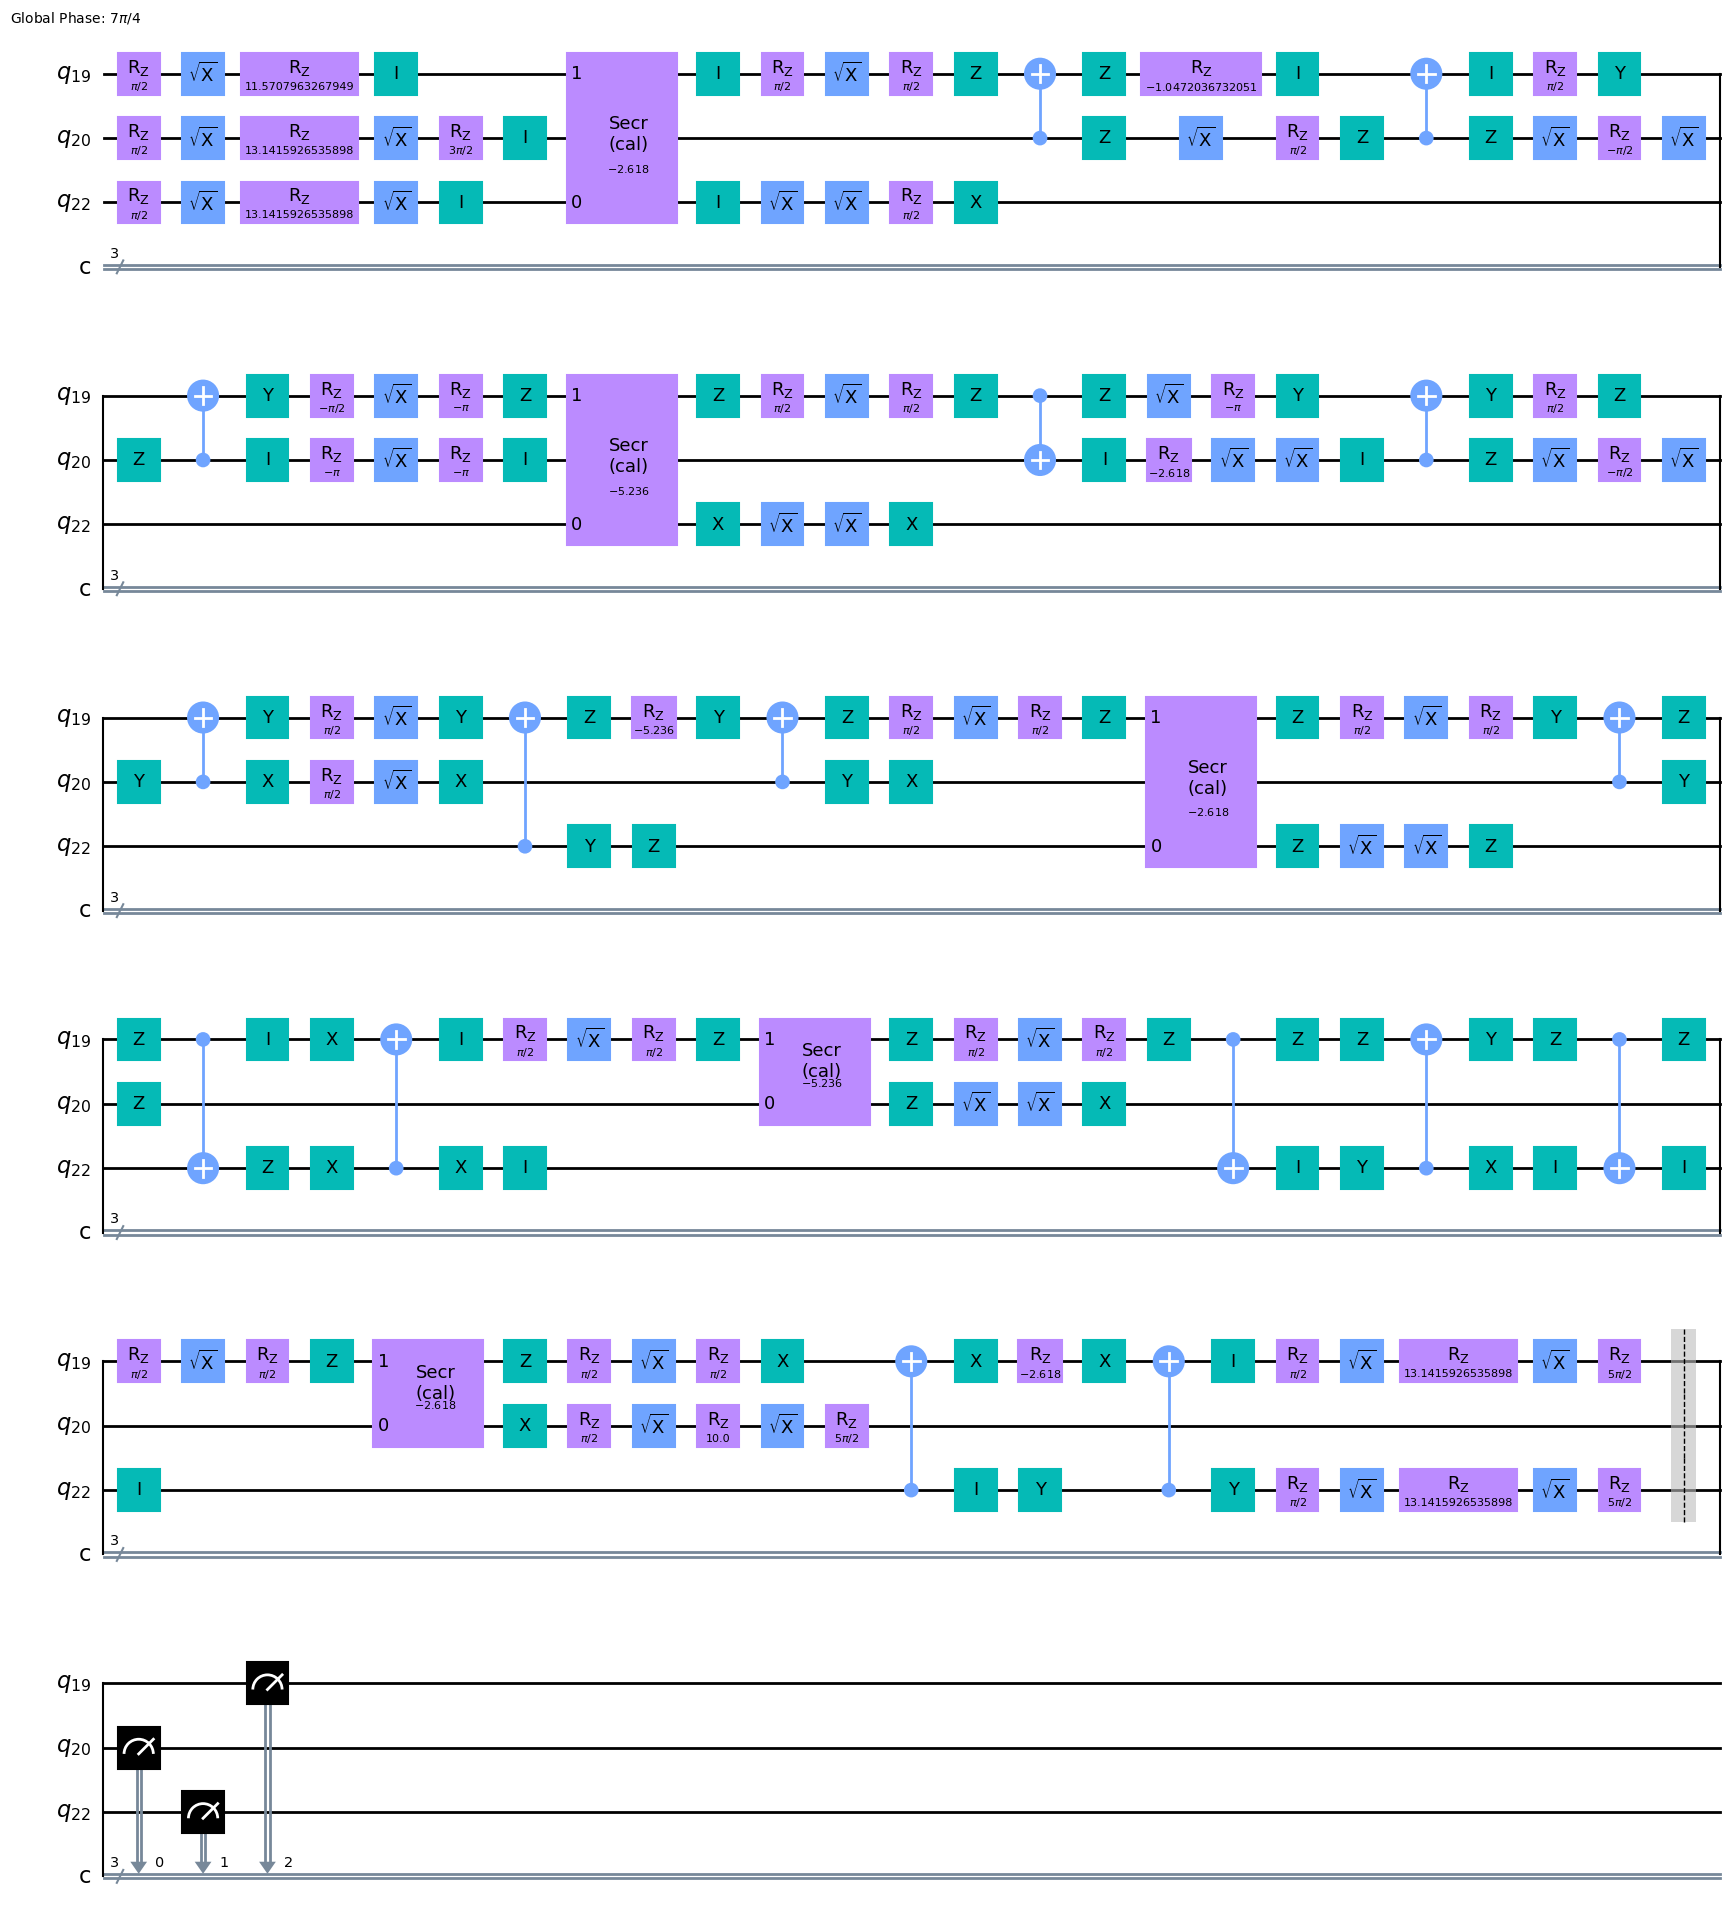

In [11]:
twirled_circs[-1][-1].draw("mpl", idle_wires=False)

Look good! Now before proceeding to dynamical decoupling, we must convert to the native basis gates of the backend so that we can retrieve gate timing information, which is necessary to add dynamical decoupling passes. (Unless you set the keyword argument `transpile_added_paulis=True` in the above). You will also need to run this before running on a backend.

In [12]:
from qiskit_research.utils.convenience import transpile_added_paulis

twirled_circs_t = transpile_added_paulis(twirled_circs)

## Dynamical Decoupling

In [13]:
from qiskit_research.utils.convenience import add_dynamical_decoupling

twirled_circs_with_dd = add_dynamical_decoupling(
    twirled_circs_t, backend, "XY4", add_pulse_cals=True
)

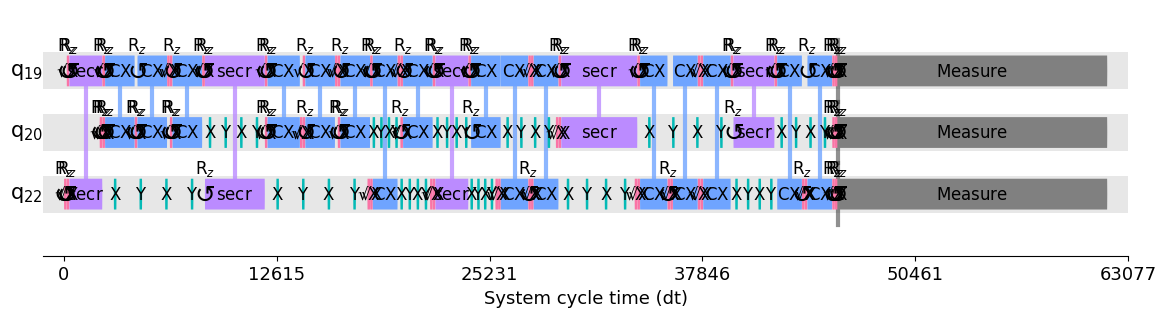

In [14]:
from qiskit.visualization import timeline_drawer

# TODO: make this look less bad
timeline_drawer(twirled_circs_with_dd[-1][-1], show_idle=False)

## Circuit Execution

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# Set the "sampler" program inputs
inputs = {"circuits": circs, "circuit_indices": list(range(len(circs)))}

# Configure backend options
options = {"backend_name": "ibmq_qasm_simulator"}

# Execute the circuit using the "sampler" program.
job = service.run(program_id="sampler", options=options, inputs=inputs)

In [16]:
counts = backend.run(circs).result().get_counts()

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 1] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 2] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 3] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 4] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 5] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 6] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 7] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 8] Circuit circuit-4591 contains invalid

QiskitError: 'ERROR:  [Experiment 0] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 1] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 2] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 3] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 4] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 5] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 6] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 7] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 8] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 9] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 10] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 11] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 12] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 13] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 14] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 15] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 16] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 17] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 18] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 19] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 20] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 21] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 22] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 23] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 24] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 25] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 26] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 27] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 28] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 29] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 30] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 31] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 32] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 33] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 34] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 35] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 36] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 37] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 38] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 39] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 40] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 41] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 42] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 43] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 44] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 45] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 46] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 47] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 48] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 49] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. [Experiment 50] Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method. ,  ERROR: Circuit circuit-4591 contains invalid instructions {"gates": {secr}} for "statevector" method.'

In [ ]:
backend.configuration().max_experiments

In [ ]:
conf.max_experiments

In [ ]:
from qiskit.providers.ibmq.managed import IBMQJobManager

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set_foo = job_manager.run(circs, backend=backend, name="foo")

In [ ]:
retrieved_foo = job_manager.retrieve_job_set(job_set_id=job_set_id, provider=provider)

## Measurement Error Mitigation

In [ ]:
from mthree import M3Mitigation

mit = M3Mitigation(backend)
mit.cals_from_system(my_layout)

In [ ]:
quasi_probs = mit.apply_correction(counts, my_layout)